## Kinerja Kendaraan Jenis Mobil Tahun 2019 - 2020 Berdasarkan Kapasitas Mesin, Efisiensi Bahan Bakar, dan Harga dengan Fuzzy System

### Anggota

### Rafid Al Afif Khumaini - 103012300200
### Faisal Surya Saputra - 103012330152
### Danang Setiyoadi - 103012300233
### Hanif Haidar Fathin Mumtaz - 103012300072

## Library

In [4]:
import numpy as np

import pandas as pd
#import pandas digunakan untuk manipulasi data untuk membaca CSV dan membuat dataframe

import matplotlib.pyplot as plt

import seaborn as sns
#seaborn digunakan untuk menampilkan visualisasi data statistik

import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from mpl_toolkits.mplot3d import Axes3D

## 1. Data Preprocessing
### Kode ini melakukan pra-pemrosesan data mobil untuk menyiapkan data yang bersih dan siap dianalisis. Pertama, data dari file "Car details v3.csv" dibaca, lalu difilter untuk hanya mengambil mobil keluaran tahun 2019 hingga 2020. Data hasil filter disimpan ke file baru dan dibaca ulang. Kemudian, nilai kosong dihapus, dan kolom 'engine' serta 'mileage' dibersihkan dari satuan teks seperti 'CC' dan 'kmpl', lalu dikonversi menjadi angka. Kolom 'selling_price' juga dikonversi agar dapat dianalisis. Setelah itu, hanya kolom penting yang disimpan: 'name', 'engine', 'mileage', dan 'selling_price'. Terakhir, data ditampilkan dan dicek strukturnya untuk memastikan siap digunakan dalam proses analisis lebih lanjut.

In [7]:
# 1. Ambil data (membaca data)
df = pd.read_csv('Car details v3.csv')
# 2. Tampilkan kolom untuk memastikan ada kolom 'year'
print(df.columns)

# 3. Filter data berdasarkan tahun 2019 sampai 2020
df_filtered = df[(df['year'] >= 2019) & (df['year'] <= 2020)]

# 4. Tampilkan hasil
print(df_filtered.head())

# 5. Simpan ke file baru
df_filtered.to_csv('Car_details_2019_2020.csv', index=False)
df = pd.read_csv('Car_details_2019_2020.csv')

# 6. Drop missing values
df.dropna(inplace=True)

# 7. Bersihkan kolom sebelum seleksi
df['engine'] = df['engine'].astype(str).str.replace('CC', '', regex=False).str.strip()
df['mileage'] = df['mileage'].astype(str).str.replace('kmpl', '', regex=False).str.strip()

# 8. Konversi ke numerik
df['engine'] = pd.to_numeric(df['engine'], errors='coerce')
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')
df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce')

# 9. Hapus baris yang masih kosong
df = df.dropna(subset=['engine', 'mileage', 'selling_price'])

# 10. Sekarang bisa dipakai
df = df[['name','engine', 'mileage', 'selling_price']]

print(df.to_string(index=False))
df.info()
df.describe()

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')
                                  name  year  selling_price  km_driven  \
35    Maruti Alto 800 CNG LXI Optional  2019         330000      10000   
36          Maruti Alto K10 VXI Airbag  2019         366000      15000   
37    Hyundai Verna VTVT 1.6 SX Option  2019        1149000       5000   
41  Jeep Compass 1.4 Limited Plus BSIV  2019        2100000       5000   
66             Maruti Baleno Delta 1.2  2019         650000      30000   

      fuel seller_type transmission         owner      mileage   engine  \
35     CNG  Individual       Manual  Second Owner  33.44 km/kg   796 CC   
36  Petrol  Individual       Manual   First Owner   23.95 kmpl   998 CC   
37  Petrol  Individual       Manual   First Owner    17.0 kmpl  1591 CC   
41  Petrol  Individual    Automatic   First Owner    16.0 kmpl  

,engine,mileage,selling_price
count,647.000000,647.000000,6.470000e+02
mean,1484.242658,19.803323,1.696294e+06
std,465.715959,3.365940,1.805701e+06
min,796.000000,0.000000,2.200000e+05
25%,1197.000000,17.300000,6.000000e+05
50%,1199.000000,19.500000,7.790000e+05
75%,1969.000000,22.000000,1.700000e+06
max,2999.000000,28.400000,7.200000e+06


## 2. Variable and Membership Function
### Bagian kode ini bertujuan untuk membangun sistem logika fuzzy dengan mendefinisikan variabel input dan output berdasarkan distribusi data mobil. Tiga variabel input didefinisikan: engine (kapasitas mesin dalam CC), mileage (efisiensi bahan bakar dalam km/l), dan price (harga dalam INR). Masing-masing variabel memiliki rentang nilai (universe) yang diambil dari nilai minimum dan maksimum di dataset. Kemudian, satu variabel output didefinisikan, yaitu performance, yang merepresentasikan kinerja kendaraan dalam skala 0–100.

### Setiap variabel input dan output memiliki fungsi keanggotaan (membership function) berbentuk segitiga (trimf) yang digunakan untuk mengelompokkan nilai ke dalam kategori fuzzy. Misalnya, kapasitas mesin (engine) dikategorikan sebagai small, medium, dan large, berdasarkan rentang tertentu. Hal serupa dilakukan untuk mileage (low, medium, high) dan price (low, medium, high). Untuk output performance, kategorinya adalah low, medium, dan high.

### Terakhir, kode view() digunakan untuk menampilkan visualisasi kurva keanggotaan masing-masing variabel agar pengguna bisa memahami cara nilai-nilai diklasifikasikan secara fuzzy dalam sistem ini.

C:\Users\Rafid\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


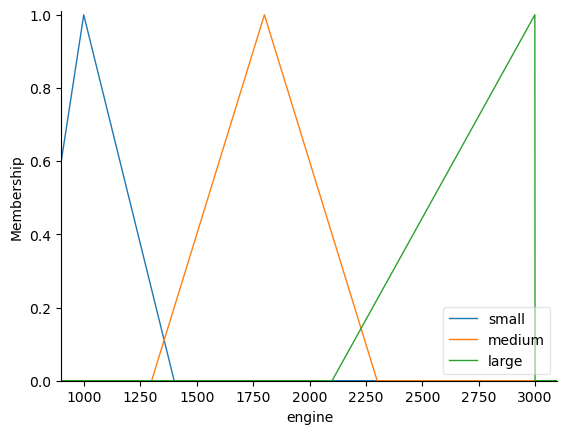

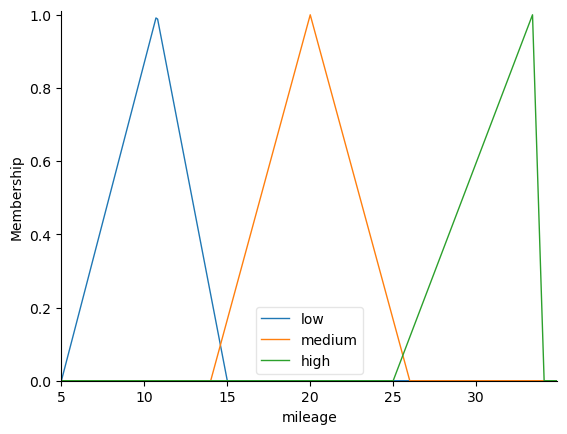

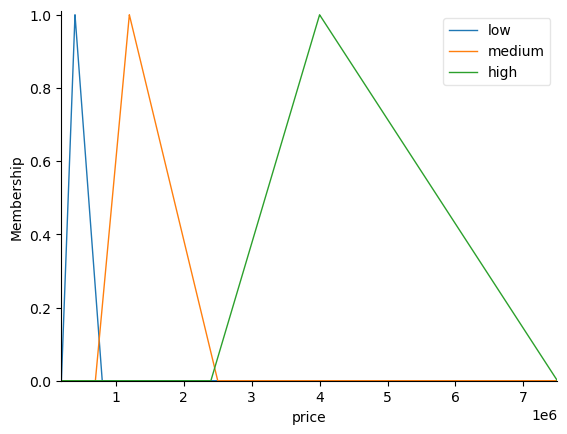

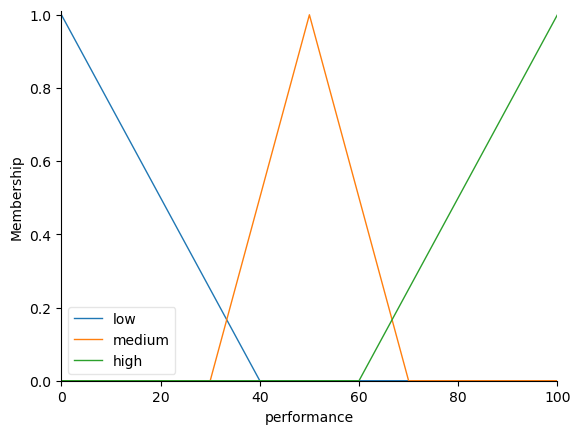

In [10]:
# Definisi variabel fuzzy berdasarkan distribusi data
# Input Variabel
engine = ctrl.Antecedent(np.arange(900, 3100, 1), 'engine') # Min 999 (CC) -  Max 2999 (CC) di DataFrame
mileage = ctrl.Antecedent(np.arange(5, 35, 0.1), 'mileage') # Min 10.75 kmpl - Max 33.4 kmpl di DataFrame
price = ctrl.Antecedent(np.arange(200000, 7500001, 1000), 'price') # Min 220000 (INR) - Max 7200000 (INR) di DataFrame

# Output Variabel
performance = ctrl.Consequent(np.arange(0, 101, 1), 'performance')

#Fungsi Keanggotaan
# Kapasitas Mesin
engine['small'] = fuzz.trimf(engine.universe, [750, 999, 1400])
engine['medium'] = fuzz.trimf(engine.universe, [1300, 1800, 2300])
engine['large'] = fuzz.trimf(engine.universe, [2100, 2999, 3000])


# Efisiensi BBM
mileage['low'] = fuzz.trimf(mileage.universe, [5, 10.75, 15])
mileage['medium'] = fuzz.trimf(mileage.universe, [14, 20, 26])
mileage['high'] = fuzz.trimf(mileage.universe, [25, 33.4, 34.1])


# Harga
price['low'] = fuzz.trimf(price.universe, [200000, 400000, 800000])
price['medium'] = fuzz.trimf(price.universe, [700000, 1200000, 2500000])
price['high'] = fuzz.trimf(price.universe, [2400000, 4000000, 7500000])

# Kinerja Kendaraan
performance['low'] = fuzz.trimf(performance.universe, [0, 0, 40])
performance['medium'] = fuzz.trimf(performance.universe, [30, 50, 70])
performance['high'] = fuzz.trimf(performance.universe, [60, 100, 100])


engine.view()
mileage.view()
price.view()
performance.view()

## 3. Rules
### Pada bagian ini, sistem fuzzy dibentuk dengan menyusun 27 aturan fuzzy (3×3×3 kombinasi) yang mencerminkan hubungan antara tiga variabel input: kapasitas mesin (engine), efisiensi bahan bakar (mileage), dan harga (price), terhadap variabel output yaitu kinerja kendaraan (performance). Setiap aturan menggunakan operator logika fuzzy AND (&), dan ditulis menggunakan ctrl.Rule().

### Aturan-aturan ini menggabungkan setiap kombinasi dari tiga tingkat keanggotaan masing-masing input (small/medium/large untuk engine, low/medium/high untuk mileage dan price) untuk menghasilkan kesimpulan dalam bentuk kategori performance (low, medium, atau high). Misalnya, jika sebuah mobil memiliki mesin kecil, efisiensi rendah, dan harga tinggi, maka sistem menganggap kinerjanya rendah. Sebaliknya, jika mesin besar, efisiensi tinggi, dan harga tinggi, maka dianggap memiliki kinerja tinggi.

### Dengan adanya 27 aturan ini, sistem fuzzy dapat secara fleksibel mengevaluasi kinerja mobil berdasarkan kombinasi tiga aspek utama yang umum dipertimbangkan dalam penilaian kendaraan.


In [13]:
# Buat 3x3x3 = 27 aturan fuzzy
rules = [
    ctrl.Rule(engine['small'] & mileage['low'] & price['low'], performance['low']),
    ctrl.Rule(engine['small'] & mileage['low'] & price['medium'], performance['low']),
    ctrl.Rule(engine['small'] & mileage['low'] & price['high'], performance['low']),
    ctrl.Rule(engine['small'] & mileage['medium'] & price['low'], performance['medium']),
    ctrl.Rule(engine['small'] & mileage['medium'] & price['medium'], performance['medium']),
    ctrl.Rule(engine['small'] & mileage['medium'] & price['high'], performance['low']),
    ctrl.Rule(engine['small'] & mileage['high'] & price['low'], performance['medium']),
    ctrl.Rule(engine['small'] & mileage['high'] & price['medium'], performance['medium']),
    ctrl.Rule(engine['small'] & mileage['high'] & price['high'], performance['medium']),

    ctrl.Rule(engine['medium'] & mileage['low'] & price['low'], performance['medium']),
    ctrl.Rule(engine['medium'] & mileage['low'] & price['medium'], performance['medium']),
    ctrl.Rule(engine['medium'] & mileage['low'] & price['high'], performance['low']),
    ctrl.Rule(engine['medium'] & mileage['medium'] & price['low'], performance['medium']),
    ctrl.Rule(engine['medium'] & mileage['medium'] & price['medium'], performance['high']),
    ctrl.Rule(engine['medium'] & mileage['medium'] & price['high'], performance['medium']),
    ctrl.Rule(engine['medium'] & mileage['high'] & price['low'], performance['high']),
    ctrl.Rule(engine['medium'] & mileage['high'] & price['medium'], performance['high']),
    ctrl.Rule(engine['medium'] & mileage['high'] & price['high'], performance['medium']),

    ctrl.Rule(engine['large'] & mileage['low'] & price['low'], performance['low']),
    ctrl.Rule(engine['large'] & mileage['low'] & price['medium'], performance['low']),
    ctrl.Rule(engine['large'] & mileage['low'] & price['high'], performance['medium']),
    ctrl.Rule(engine['large'] & mileage['medium'] & price['low'], performance['medium']),
    ctrl.Rule(engine['large'] & mileage['medium'] & price['medium'], performance['high']),
    ctrl.Rule(engine['large'] & mileage['medium'] & price['high'], performance['high']),
    ctrl.Rule(engine['large'] & mileage['high'] & price['low'], performance['high']),
    ctrl.Rule(engine['large'] & mileage['high'] & price['medium'], performance['high']),
    ctrl.Rule(engine['large'] & mileage['high'] & price['high'], performance['high']),
]


## 4. Defuzzification
### Pada tahap ini, sistem fuzzy yang telah didefinisikan sebelumnya mulai diimplementasikan dan disimulasikan. Pertama, objek kontrol sistem fuzzy dibuat dengan ctrl.ControlSystem(rules), di mana aturan-aturan fuzzy yang telah dibuat sebelumnya dijadikan dasar pengambilan keputusan. Kemudian, dibuat simulasi dari sistem ini dengan ctrl.ControlSystemSimulation(performance_ctrl).

### Setelah itu, nilai input diberikan secara manual sebagai contoh, yaitu kapasitas mesin sebesar 1591 CC, efisiensi bahan bakar 17.0 km/l, dan harga kendaraan 1.149.000 INR. Sistem fuzzy kemudian memproses input ini menggunakan metode Mamdani melalui performance_sim.compute().

### Hasil akhirnya adalah nilai output berupa kinerja kendaraan yang dihitung berdasarkan aturan fuzzy. Nilai ini ditampilkan dalam bentuk angka dan juga divisualisasikan dalam grafik dengan performance.view(sim=performance_sim), yang memperlihatkan derajat keanggotaan output dalam kategori low, medium, atau high.

Kinerja Kendaraan (Mamdani): 84.44


C:\Users\Rafid\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


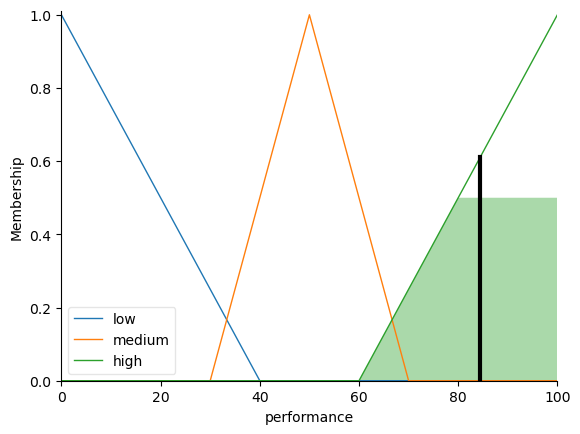

In [16]:
#Bangun dan simulasi sistem fuzzy
# Buat kontrol sistem fuzzy
performance_ctrl = ctrl.ControlSystem(rules)
performance_sim = ctrl.ControlSystemSimulation(performance_ctrl)
print(performance_ctrl.rules)

performance_sim.input['engine'] = 1591       # contoh nilai kapasitas mesin
performance_sim.input['mileage'] = 17.0      # contoh efisiensi BBM
performance_sim.input['price'] = 1149000	 # contoh harga

performance_sim.compute()
print(f"Kinerja Kendaraan (Mamdani): {performance_sim.output['performance']:.2f}")
performance.view(sim=performance_sim)



## Sugeno
### Membangun sistem logika fuzzy model Sugeno, yang berbeda dari Mamdani karena menghasilkan output dalam bentuk nilai numerik langsung melalui fungsi linier. Pertama-tama, didefinisikan fungsi keanggotaan (fuzzy_membership_...) untuk masing-masing variabel input: engine, mileage, dan price, menggunakan metode segitiga seperti pada Mamdani, tetapi ditulis dalam bentuk fungsi matematis secara manual. Nilai-nilai input juga dinormalisasi ke rentang [0, 1] agar dapat digunakan dalam perhitungan fungsi output Sugeno.

### Kemudian, disusun rule base (aturan) secara otomatis dengan menggabungkan semua kemungkinan kombinasi (3×3×3) dari istilah fuzzy (small, medium, large, dll). Masing-masing aturan memiliki fungsi output linier (z_func) yang menghasilkan skor kinerja berdasarkan kontribusi bobot masing-masing input: performance = 50 + 20*engine + 30*mileage - 10*price. Nilai akhir dihitung sebagai rata-rata tertimbang (weighted average) dari semua output aturan, di mana bobotnya adalah tingkat keanggotaan minimum dari setiap input dalam aturan tersebut.

### Terakhir, diberikan contoh input (engine = 1591, mileage = 17.0, price = 1.149.000) untuk disimulasikan, dan sistem Sugeno memberikan output numerik yang menunjukkan tingkat kinerja kendaraan secara langsung berdasarkan logika fuzzy Sugeno.

In [19]:
# Fungsi keanggotaan (tanpa perubahan)
def fuzzy_membership_engine(x):
    return {
        'small': max(min((x - 750)/(999 - 750), (1400 - x)/(1400 - 999)), 0),
        'medium': max(min((x - 1300)/(1800 - 1300), (2300 - x)/(2300 - 1800)), 0),
        'large': max(min((x - 2100)/(2999 - 2100), (3000 - x)/(3000 - 2999)), 0),
    }

def fuzzy_membership_mileage(x):
    return {
        'low': max(min((x - 5)/(10.75 - 5), (15 - x)/(15 - 10.75)), 0),
        'medium': max(min((x - 14)/(20 - 14), (26 - x)/(26 - 20)), 0),
        'high': max(min((x - 25)/(33.4 - 25), (34.1 - x)/(34.1 - 33.4)), 0),
    }

def fuzzy_membership_price(x):
    return {
        'low': max(min((x - 200000)/(400000 - 200000), (800000 - x)/(800000 - 400000)), 0),
        'medium': max(min((x - 700000)/(1200000 - 700000), (2500000 - x)/(2500000 - 1200000)), 0),
        'high': max(min((x - 2400000)/(4000000 - 2400000), (7500000 - x)/(7500000 - 4000000)), 0),
    }

# Fungsi normalisasi ke [0, 1]
def normalize_inputs(engine, mileage, price):
    e_norm = (engine - 750) / (3000 - 750)
    m_norm = (mileage - 5) / (34.1 - 5)
    p_norm = (price - 200000) / (7500000 - 200000)
    return e_norm, m_norm, p_norm

# Rule base Sugeno yang diperbaiki
def rule_base(engine, mileage, price):
    eng_mf = fuzzy_membership_engine(engine)
    mil_mf = fuzzy_membership_mileage(mileage)
    pri_mf = fuzzy_membership_price(price)

    # Normalisasi input
    e_norm, m_norm, p_norm = normalize_inputs(engine, mileage, price)

    # Aturan dengan z_func disesuaikan menggunakan nilai normalisasi
    rules = []
    terms = ['small', 'medium', 'large']
    levels = ['low', 'medium', 'high']

    for eng_term in terms:
        for mil_term in levels:
            for pri_term in levels:
                rules.append((
                    eng_term, mil_term, pri_term,
                    lambda e=e_norm, m=m_norm, p=p_norm: 50 + 20 * e + 30 * m - 10 * p
                ))

    weighted_sum = 0
    weight_total = 0

    for rule in rules:
        eng_term, mil_term, pri_term, z_func = rule
        w = min(eng_mf[eng_term], mil_mf[mil_term], pri_mf[pri_term])
        z = z_func()
        weighted_sum += w * z
        weight_total += w

    if weight_total == 0:
        return 0
    return weighted_sum / weight_total

# Input uji coba
engine_input = 1591
mileage_input = 17.0
price_input = 1149000

# Simulasi Sugeno
sugeno_output = rule_base(engine_input, mileage_input, price_input)
print(f"Hasil Sugeno untuk input:")
print(f"  Engine        : {engine_input}")
print(f"  Mileage       : {mileage_input}")
print(f"  Selling Price : {price_input}")
print(f"=> Kinerja Kendaraan (Sugeno): {sugeno_output:.2f}")


Hasil Sugeno untuk input:
  Engine        : 1591
  Mileage       : 17.0
  Selling Price : 1149000
=> Kinerja Kendaraan (Sugeno): 68.55


## Sugeno Visualize
### Bagian kode ini digunakan untuk memvisualisasikan permukaan output dari sistem logika fuzzy Sugeno dengan memperbaiki satu variabel input, yaitu price, agar bisa dianalisis pengaruh dua variabel lainnya terhadap output sistem. Dalam hal ini, variabel price ditetapkan konstan pada nilai 1.149.000, sedangkan dua variabel lainnya—kapasitas mesin (engine) dan efisiensi bahan bakar (mileage)—dibuat bervariasi dalam rentang yang telah ditentukan.
### Nilai engine dibuat dalam rentang 750 hingga 5200 cc dan mileage dalam rentang 5 hingga 35 km/l, masing-masing dengan 30 titik data yang merata menggunakan np.linspace(). Kemudian, np.meshgrid() digunakan untuk membentuk grid dua dimensi yang mencakup semua kombinasi nilai dari kedua variabel tersebut. Grid ini mewakili seluruh titik yang akan diuji dalam ruang input fuzzy.
### Untuk setiap kombinasi nilai engine dan mileage dalam grid, fungsi rule_base() dipanggil bersama nilai tetap price untuk menghasilkan output sistem, yaitu nilai performance. Output tersebut disimpan dalam matriks dua dimensi z_grid, yang strukturnya sama dengan grid input.
### Visualisasi kemudian dibuat dengan grafik permukaan 3D menggunakan matplotlib, di mana sumbu X menunjukkan nilai engine, sumbu Y menunjukkan nilai mileage, dan sumbu Z menunjukkan nilai performance yang dihitung. Grafik ini memberikan gambaran visual yang jelas tentang bagaimana performa sistem fuzzy Sugeno berubah terhadap variasi dua input ketika satu input lainnya tetap, sehingga sangat membantu dalam analisis sistem dan pengambilan keputusan.

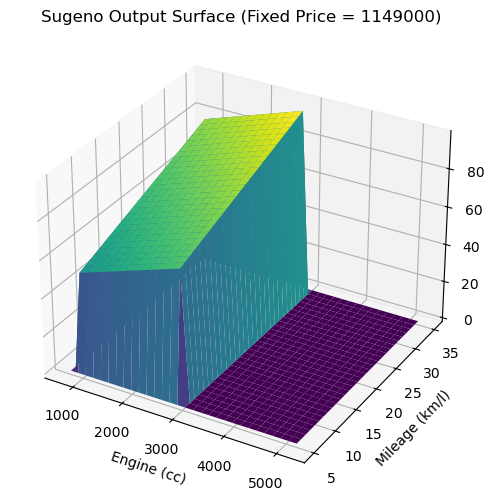

In [22]:
# Contoh: fix satu variabel (price), visualisasikan terhadap dua variabel lainnya
fixed_price = 1149000  # sesuai input uji coba

engine_range = np.linspace(750, 5200, 30)
mileage_range = np.linspace(5, 35, 30)

engine_grid, mileage_grid = np.meshgrid(engine_range, mileage_range)
z_grid = np.zeros_like(engine_grid)

for i in range(engine_grid.shape[0]):
    for j in range(engine_grid.shape[1]):
        e = engine_grid[i, j]
        m = mileage_grid[i, j]
        z_grid[i, j] = rule_base(e, m, fixed_price)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(engine_grid, mileage_grid, z_grid, cmap='viridis')
ax.set_title("Sugeno Output Surface (Fixed Price = 1149000)")
ax.set_xlabel("Engine (cc)")
ax.set_ylabel("Mileage (km/l)")
ax.set_zlabel("Performance")
plt.show()


## 5. Classification and Calculate Scores
### Bagian kode ini digunakan untuk menghitung skor performa kendaraan menggunakan dua metode logika fuzzy, yaitu Mamdani dan Sugeno, kemudian mengklasifikasikan hasilnya ke dalam kategori kinerja. Data kendaraan diambil dari DataFrame (df), yang berisi atribut seperti nama kendaraan, kapasitas mesin (engine), efisiensi bahan bakar (mileage), dan harga jual (selling_price).
### Untuk metode Mamdani, sistem kontrol fuzzy dibangun dari kumpulan aturan fuzzy (rules) menggunakan ctrl.ControlSystem. Simulasi dilakukan melalui fungsi mamdani_simulation, yang menerima tiga input numerik (engine, mileage, price), lalu menyetel input pada sistem dan memanggil .compute() untuk menghasilkan nilai output performance. Jika terjadi kesalahan dalam proses komputasi, sistem akan mengembalikan skor default 0 agar program tetap berjalan.
### Sedangkan untuk metode Sugeno, simulasi dilakukan menggunakan fungsi sugeno_simulation, yang memanggil langsung fungsi rule_base() sebagai logika fuzzy berbasis aturan Sugeno. Fungsi ini juga menerima tiga input numerik dan mengembalikan skor performa secara langsung.
### Setelah skor diperoleh dari kedua metode, langkah selanjutnya adalah mengklasifikasikan hasil skor ke dalam tiga kategori:
### "Buruk" jika skor < 40

### "Cukup" jika skor antara 40 dan 69

### "Bagus" jika skor ≥ 70
### Klasifikasi ini dilakukan menggunakan fungsi classify_kinerja().

### Terakhir, kode melakukan iterasi pada setiap baris dalam DataFrame, menghitung skor Mamdani dan Sugeno, mengklasifikasikannya, lalu menyimpan semua hasil tersebut ke dalam list results. Setiap elemen pada list ini adalah dictionary yang berisi nama kendaraan, input numerik, skor fuzzy, dan label klasifikasinya dari kedua metode.

In [25]:
mamdani_ctrl = ctrl.ControlSystem(rules)  # Rules
mamdani_sim = ctrl.ControlSystemSimulation(mamdani_ctrl)


# Fungsi untuk Mamdani (fixed version)
def mamdani_simulation(engine, mileage, price):
    try:
        # Membuat simulasi baru untuk tiap evaluasi
        sim = ctrl.ControlSystemSimulation(mamdani_ctrl)
        sim.input['engine'] = engine
        sim.input['mileage'] = mileage
        sim.input['price'] = price
        sim.compute()
        return sim.output['performance']
    except:
        # Return default value jika gagal compute
        return 0

# Fungsi untuk Sugeno (menggunakan rule_base function)
def sugeno_simulation(engine, mileage, price):
    return rule_base(engine, mileage, price)

# Klasifikasi
def classify_kinerja(score):
    if score < 40:
        return "Buruk"
    elif score < 70:
        return "Cukup"
    else:
        return "Bagus"

print(df)

# Klasifikasi scores untuk semua data
results = []

for index, row in df.iterrows():
    name = row['name']
    engine = row['engine']
    mileage = row['mileage']
    price = row['selling_price']
    
    # Hitung skor fuzzy
    mamdani_score = mamdani_simulation(engine, mileage, price)
    sugeno_score = sugeno_simulation(engine, mileage, price)
    
    # Klasifikasi
    mamdani_label = classify_kinerja(mamdani_score)
    sugeno_label = classify_kinerja(sugeno_score)
    
    results.append({
        'name': name,
        'engine': engine,
        'mileage': mileage,
        'price': price,
        'mamdani_score': mamdani_score,
        'mamdani_label': mamdani_label,
        'sugeno_score': sugeno_score,
        'sugeno_label': sugeno_label
    })

                                   name  engine  mileage  selling_price
1            Maruti Alto K10 VXI Airbag     998    23.95         366000
2      Hyundai Verna VTVT 1.6 SX Option    1591    17.00        1149000
3    Jeep Compass 1.4 Limited Plus BSIV    1368    16.00        2100000
4               Maruti Baleno Delta 1.2    1197    21.40         650000
5     Maruti Vitara Brezza ZDi Plus AMT    1248    24.30        1025000
..                                  ...     ...      ...            ...
652            Maruti Ciaz Alpha Diesel    1248    28.09        1025000
653              Maruti S-Presso VXI AT     998    21.70         475000
654          Ford Figo 1.2P Titanium MT    1196    18.16         530000
655            Maruti Ciaz Alpha Diesel    1248    28.09        1025000
656            Kia Seltos HTX Plus AT D    1493    17.80        1575000

[647 rows x 4 columns]


## 6. Display Results
### Bagian kode ini berfungsi untuk menampilkan hasil akhir penilaian fuzzy Mamdani dan Sugeno dalam bentuk tabel yang rapi dan mudah dibaca. Setelah proses perhitungan dan klasifikasi skor selesai, seluruh hasil yang tersimpan dalam list results dikonversi menjadi sebuah DataFrame bernama results_df menggunakan pustaka pandas.
### Nama-nama kolom kemudian diubah ke dalam bahasa Indonesia agar lebih deskriptif dan mudah dipahami, seperti name menjadi Nama Mobil, engine menjadi Engine (cc), mileage menjadi Konsumsi BBM (kmpl), dan seterusnya. Selanjutnya, kolom Harga (INR) diformat menggunakan f-string agar tampil dengan pemisah ribuan (misalnya: 1,149,000), sedangkan kolom Skor Mamdani dan Skor Sugeno dibulatkan hingga dua angka di belakang koma.
### Pengguna dapat memilih untuk mengurutkan data berdasarkan salah satu kolom, misalnya berdasarkan harga, konsumsi BBM, kapasitas mesin, atau skor fuzzy. Untuk itu, dibuat map yang mengubah data pada kolom-kolom tersebut menjadi numerik secara sementara (jika dibutuhkan) agar bisa dilakukan proses pengurutan (sort_values). Setelah proses pengurutan selesai, kolom sementara _sort_col_ dihapus agar tidak ikut tampil.
### Terakhir, seluruh isi DataFrame ditampilkan dalam bentuk tabel lengkap menggunakan to_string(), tanpa indeks baris, dan dengan informasi tambahan mengenai kolom yang digunakan untuk pengurutan. Tabel ini memberikan gambaran yang jelas dan ringkas mengenai performa kendaraan berdasarkan dua pendekatan fuzzy yang digunakan, serta memudahkan perbandingan antar kendaraan.

In [27]:
sort_by = 'Harga (INR)'    # Sorting: 'Harga (INR)', 'Engine (cc)', 'Konsumsi BBM (kmpl)', 'Skor Mamdani', 'Skor Sugeno'
ascending = False          # True = dari kecil ke besar, False = dari besar ke kecil

# Convert ke DataFrame
results_df = pd.DataFrame(results)

# Rename kolom
results_df.rename(columns={
    'name': 'Nama Mobil',
    'engine': 'Engine (cc)',
    'mileage': 'Konsumsi BBM (kmpl)',
    'price': 'Harga (INR)',
    'mamdani_score': 'Skor Mamdani',
    'mamdani_label': 'Label Mamdani',
    'sugeno_score': 'Skor Sugeno',
    'sugeno_label': 'Label Sugeno'
}, inplace=True)

# Format kolom
results_df['Harga (INR)'] = results_df['Harga (INR)'].apply(lambda x: f"{x:,.0f}")
results_df['Skor Mamdani'] = results_df['Skor Mamdani'].apply(lambda x: f"{x:.2f}")
results_df['Skor Sugeno'] = results_df['Skor Sugeno'].apply(lambda x: f"{x:.2f}")

# Convert kolom sort ke numerik sementara untuk sorting
numeric_sort_map = {
    'Harga (INR)': lambda df: df['Harga (INR)'].str.replace(',', '').astype(int),
    'Skor Mamdani': lambda df: df['Skor Mamdani'].astype(float),
    'Skor Sugeno': lambda df: df['Skor Sugeno'].astype(float),
    'Konsumsi BBM (kmpl)': lambda df: df['Konsumsi BBM (kmpl)'].astype(float),
    'Engine (cc)': lambda df: df['Engine (cc)'].astype(int)
}

if sort_by in numeric_sort_map:
    results_df['_sort_col_'] = numeric_sort_map[sort_by](results_df)
    results_df.sort_values(by='_sort_col_', ascending=ascending, inplace=True)
    results_df.drop(columns=['_sort_col_'], inplace=True)
else:
    results_df.sort_values(by=sort_by, ascending=ascending, inplace=True)

# Tampilkan seluruh hasil dengan format tabel
print("\nHasil Penilaian Fuzzy (Mamdani dan Sugeno) - Urut berdasarkan:", sort_by)
print(results_df.to_string(index=False))



Hasil Penilaian Fuzzy (Mamdani dan Sugeno) - Urut berdasarkan: Harga (INR)
                                     Nama Mobil  Engine (cc)  Konsumsi BBM (kmpl) Harga (INR) Skor Mamdani Label Mamdani Skor Sugeno Label Sugeno
                          BMW X7 xDrive 30d DPE         2993                13.38   7,200,000        50.00         Cukup       68.99        Cukup
                         Audi A6 35 TFSI Matrix         1798                15.26   6,523,000        50.00         Cukup       61.23        Cukup
                         Audi A6 35 TFSI Matrix         1798                15.26   6,223,000        50.00         Cukup       61.64        Cukup
                         Audi A6 35 TFSI Matrix         1798                15.26   5,923,000        50.00         Cukup       62.05        Cukup
                     BMW X4 M Sport X xDrive20d         1995                16.78   5,800,000        50.00         Cukup       65.54        Cukup
                     BMW X4 M Sport X xDrive20d 

## 7. Evaluation
### Bagian ini bertujuan untuk mengevaluasi seberapa baik hasil prediksi metode logika fuzzy Sugeno jika dibandingkan dengan metode Mamdani, yang dalam konteks ini dianggap sebagai acuan atau "ground truth". Evaluasi dilakukan dengan membandingkan label klasifikasi performa kendaraan yang dihasilkan oleh kedua metode.
### Pertama, sistem mengambil dua buah kolom dari results_df, yaitu kolom ‘Label Mamdani’ sebagai label sebenarnya, dan ‘Label Sugeno’ sebagai label prediksi. Kedua kolom ini berisi kategori kinerja kendaraan seperti "Buruk", "Cukup", atau "Bagus".
### Untuk mengukur kesesuaian antara kedua label tersebut, dua metrik digunakan:
### Accuracy mengukur proporsi prediksi yang tepat dari keseluruhan data,

### F1 Score (weighted) menghitung rata-rata harmonik dari presisi dan recall untuk setiap kelas (kategori), lalu menimbangnya berdasarkan jumlah data di tiap kelas. Ini penting karena klasifikasi memiliki lebih dari dua kelas (multiclass).

### Hasil evaluasi kemudian dicetak ke layar dalam format desimal 4 angka di belakang koma. Nilai ini memberikan gambaran sejauh mana metode Sugeno mampu meniru hasil klasifikasi metode Mamdani dalam menilai performa kendaraan.

In [29]:
# Ambil label
true_labels = results_df['Label Mamdani']
pred_labels = results_df['Label Sugeno']

# Hitung metrik
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')  # karena multiclass

# Tampilkan hasil
print(f"\nAccuracy Sugeno terhadap Mamdani: {accuracy:.4f}")
print(f"F1 Score Sugeno terhadap Mamdani: {f1:.4f}")




Accuracy Sugeno terhadap Mamdani: 0.6770
F1 Score Sugeno terhadap Mamdani: 0.7036


## 8. Visualization
### Bagian ini bertujuan untuk membandingkan dua jenis bentuk fungsi keanggotaan fuzzy, yaitu segitiga (triangular) dan trapesium (trapezoidal), yang digunakan dalam mendefinisikan kategori fuzzy dari setiap variabel dalam sistem. Variabel yang divisualisasikan meliputi tiga variabel input—engine (kapasitas mesin), mileage (efisiensi bahan bakar), dan price (harga mobil)—serta satu variabel output, yaitu performance (kinerja mobil).
### Untuk masing-masing variabel, sistem terlebih dahulu mendefinisikan domain (range nilai) yang sesuai dengan rentang data pada dataset. Selanjutnya, dibentuk fungsi keanggotaan segitiga dan trapesium untuk setiap kategori dari variabel tersebut, misalnya untuk engine terdapat kategori small, medium, dan large. Setiap kategori diwakili oleh dua garis: satu bergaya putus-putus untuk bentuk segitiga, dan satu bergaya solid untuk bentuk trapesium.
### Visualisasi ditampilkan dalam bentuk empat subplot yang memuat grafik keanggotaan fuzzy masing-masing variabel. Perbandingan ini memungkinkan pengguna untuk melihat perbedaan antara bentuk kurva segitiga dan trapesium, baik dari segi kemiringan, rentang nilai, maupun tumpang tindih antar kategori. Visualisasi ini sangat berguna untuk memahami pengaruh bentuk fungsi keanggotaan terhadap proses fuzzifikasi dan hasil evaluasi sistem fuzzy secara keseluruhan.

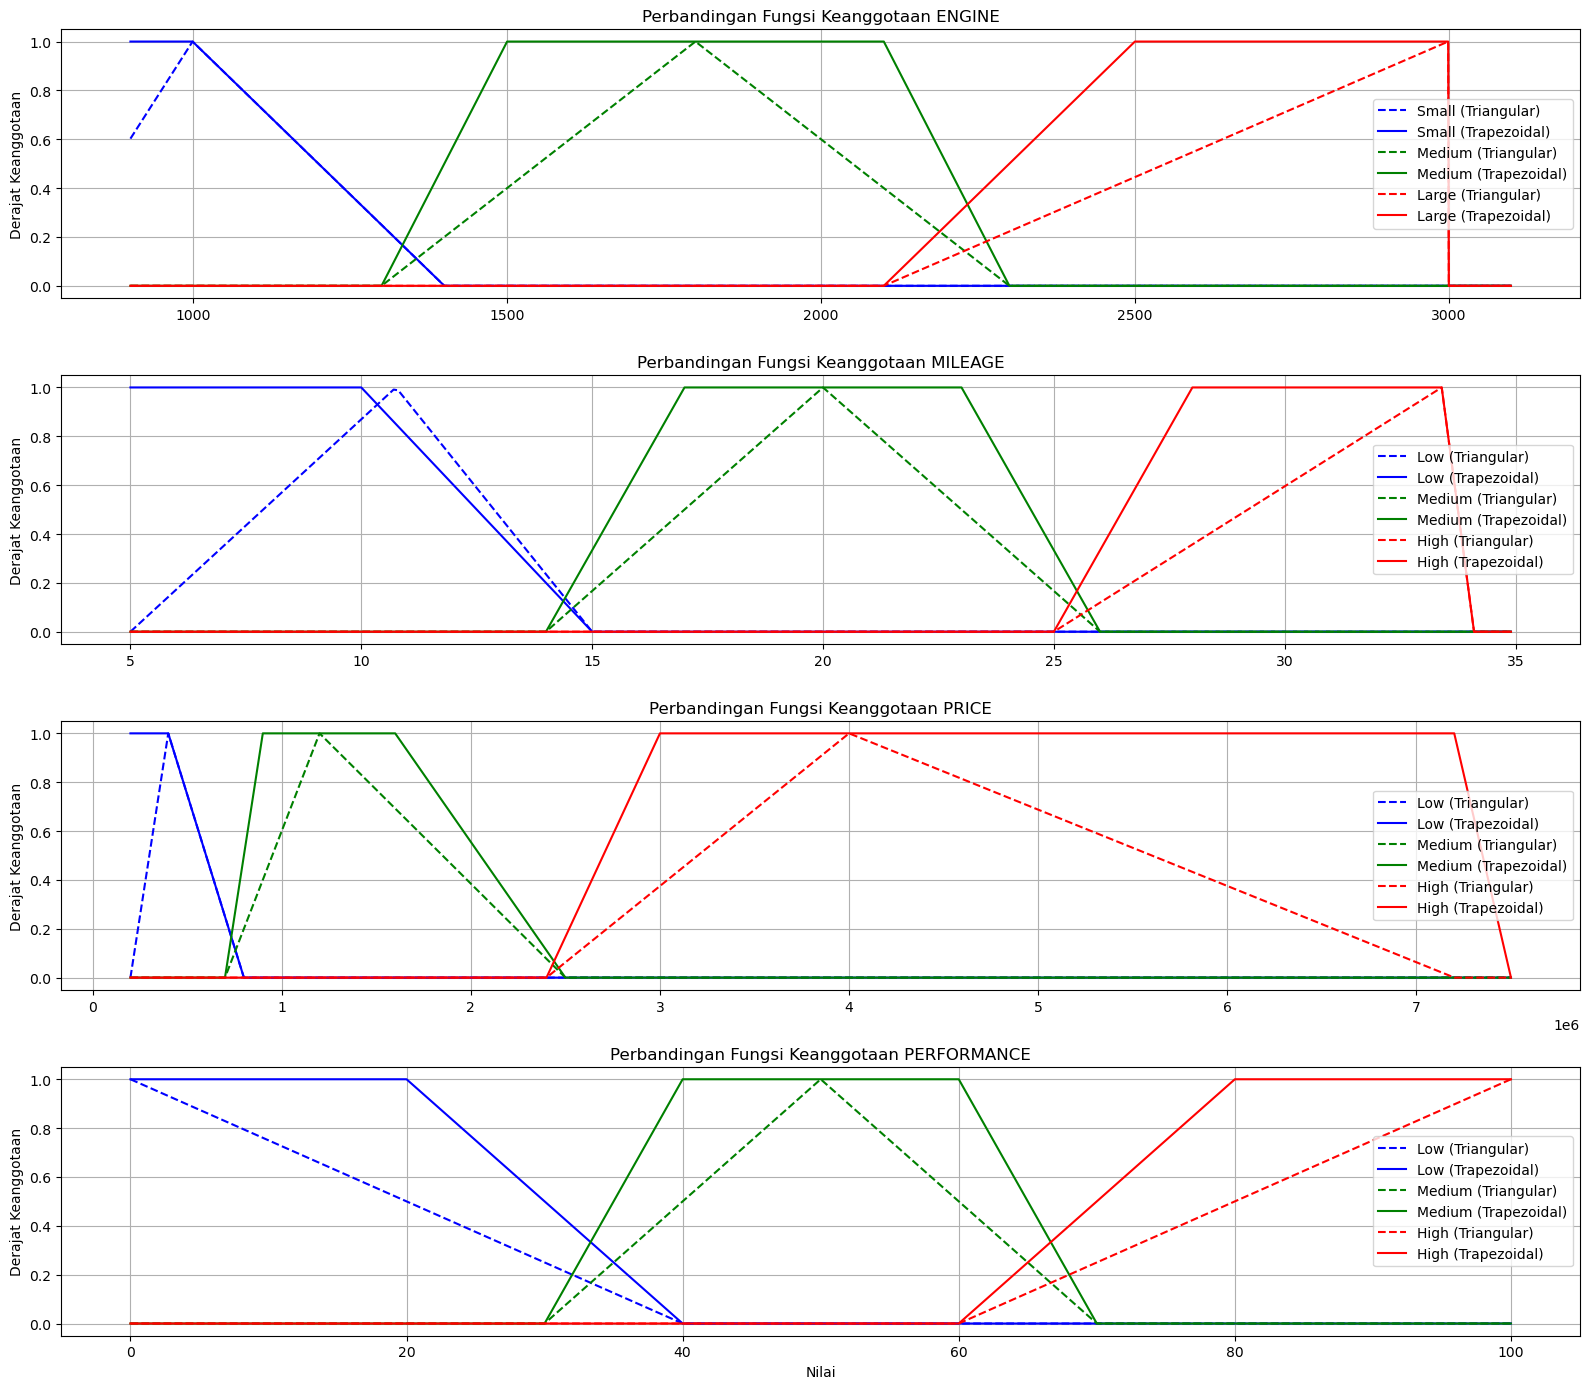

In [31]:
# Domain variabel
x_engine = np.arange(900, 3100, 1)
x_mileage = np.arange(5, 35, 0.1)
x_price = np.arange(200000, 7500001, 1000)
x_performance = np.arange(0, 101, 1)

# Fungsi keanggotaan segitiga
# Engine
engine_small_tri = fuzz.trimf(x_engine, [750, 999, 1400])
engine_medium_tri = fuzz.trimf(x_engine, [1300, 1800, 2300])
engine_large_tri = fuzz.trimf(x_engine, [2100, 2999, 3000])
# Mileage
mileage_low_tri = fuzz.trimf(x_mileage, [5, 10.75, 15])
mileage_medium_tri = fuzz.trimf(x_mileage, [14, 20, 26])
mileage_high_tri = fuzz.trimf(x_mileage, [25, 33.4, 34.1])
# Price
price_low_tri = fuzz.trimf(x_price, [200000, 400000, 800000])
price_medium_tri = fuzz.trimf(x_price, [700000, 1200000, 2500000])
price_high_tri = fuzz.trimf(x_price, [2400000, 4000000, 7200000])
# Performance
performance_low_tri = fuzz.trimf(x_performance, [0, 0, 40])
performance_medium_tri = fuzz.trimf(x_performance, [30, 50, 70])
performance_high_tri = fuzz.trimf(x_performance, [60, 100, 100])

# Fungsi keanggotaan trapesium
# Engine
engine_small_trap = fuzz.trapmf(x_engine, [750, 750, 999, 1400])
engine_medium_trap = fuzz.trapmf(x_engine, [1300, 1500, 2100, 2300])
engine_large_trap = fuzz.trapmf(x_engine, [2100, 2500, 2999, 3000])
# Mileage
mileage_low_trap = fuzz.trapmf(x_mileage, [5, 5, 10, 15])
mileage_medium_trap = fuzz.trapmf(x_mileage, [14, 17, 23, 26])
mileage_high_trap = fuzz.trapmf(x_mileage, [25, 28, 33.4, 34.1])
# Price
price_low_trap = fuzz.trapmf(x_price, [200000, 200000, 400000, 800000])
price_medium_trap = fuzz.trapmf(x_price, [700000, 900000, 1600000, 2500000])
price_high_trap = fuzz.trapmf(x_price, [2400000, 3000000, 7200000, 7500000])
# Performance
performance_low_trap = fuzz.trapmf(x_performance, [0, 0, 20, 40])
performance_medium_trap = fuzz.trapmf(x_performance, [30, 40, 60, 70])
performance_high_trap = fuzz.trapmf(x_performance, [60, 80, 100, 100])

# Plot layout 4 subplots untuk tiap variabel
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(16, 14))

# 1. ENGINE
axs[0].plot(x_engine, engine_small_tri, 'b--', label='Small (Triangular)')
axs[0].plot(x_engine, engine_small_trap, 'b-', label='Small (Trapezoidal)')
axs[0].plot(x_engine, engine_medium_tri, 'g--', label='Medium (Triangular)')
axs[0].plot(x_engine, engine_medium_trap, 'g-', label='Medium (Trapezoidal)')
axs[0].plot(x_engine, engine_large_tri, 'r--', label='Large (Triangular)')
axs[0].plot(x_engine, engine_large_trap, 'r-', label='Large (Trapezoidal)')
axs[0].set_title('Perbandingan Fungsi Keanggotaan ENGINE')
axs[0].set_ylabel('Derajat Keanggotaan')
axs[0].legend()
axs[0].grid(True)

# 2. MILEAGE
axs[1].plot(x_mileage, mileage_low_tri, 'b--', label='Low (Triangular)')
axs[1].plot(x_mileage, mileage_low_trap, 'b-', label='Low (Trapezoidal)')
axs[1].plot(x_mileage, mileage_medium_tri, 'g--', label='Medium (Triangular)')
axs[1].plot(x_mileage, mileage_medium_trap, 'g-', label='Medium (Trapezoidal)')
axs[1].plot(x_mileage, mileage_high_tri, 'r--', label='High (Triangular)')
axs[1].plot(x_mileage, mileage_high_trap, 'r-', label='High (Trapezoidal)')
axs[1].set_title('Perbandingan Fungsi Keanggotaan MILEAGE')
axs[1].set_ylabel('Derajat Keanggotaan')
axs[1].legend()
axs[1].grid(True)

# 3. PRICE
axs[2].plot(x_price, price_low_tri, 'b--', label='Low (Triangular)')
axs[2].plot(x_price, price_low_trap, 'b-', label='Low (Trapezoidal)')
axs[2].plot(x_price, price_medium_tri, 'g--', label='Medium (Triangular)')
axs[2].plot(x_price, price_medium_trap, 'g-', label='Medium (Trapezoidal)')
axs[2].plot(x_price, price_high_tri, 'r--', label='High (Triangular)')
axs[2].plot(x_price, price_high_trap, 'r-', label='High (Trapezoidal)')
axs[2].set_title('Perbandingan Fungsi Keanggotaan PRICE')
axs[2].set_ylabel('Derajat Keanggotaan')
axs[2].legend()
axs[2].grid(True)

# 4. PERFORMANCE
axs[3].plot(x_performance, performance_low_tri, 'b--', label='Low (Triangular)')
axs[3].plot(x_performance, performance_low_trap, 'b-', label='Low (Trapezoidal)')
axs[3].plot(x_performance, performance_medium_tri, 'g--', label='Medium (Triangular)')
axs[3].plot(x_performance, performance_medium_trap, 'g-', label='Medium (Trapezoidal)')
axs[3].plot(x_performance, performance_high_tri, 'r--', label='High (Triangular)')
axs[3].plot(x_performance, performance_high_trap, 'r-', label='High (Trapezoidal)')
axs[3].set_title('Perbandingan Fungsi Keanggotaan PERFORMANCE')
axs[3].set_xlabel('Nilai')
axs[3].set_ylabel('Derajat Keanggotaan')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


## Confusion Matrix
### Bagian ini bertujuan untuk mengevaluasi sejauh mana hasil klasifikasi sistem logika fuzzy Sugeno sesuai dengan sistem Mamdani yang dianggap sebagai referensi (ground truth). Evaluasi dilakukan menggunakan confusion matrix, yaitu sebuah tabel yang menggambarkan jumlah prediksi yang benar dan salah untuk masing-masing kelas: Buruk, Cukup, dan Bagus.
### Dalam kode ini, fungsi confusion_matrix() dari library sklearn.metrics digunakan untuk membandingkan label hasil klasifikasi Sugeno dengan label dari Mamdani. Matriks hasilnya divisualisasikan menggunakan ConfusionMatrixDisplay, yang memudahkan pengguna untuk melihat secara langsung seberapa sering Sugeno mengklasifikasikan mobil ke dalam kategori yang benar atau salah.
### Warna biru pada plot mencerminkan intensitas jumlah data yang termasuk dalam setiap sel matriks. Semakin gelap warna, semakin banyak jumlah data pada kategori tersebut. Dari visualisasi ini, kita dapat dengan cepat mengidentifikasi apakah Sugeno cenderung overpredict pada satu kelas tertentu atau menunjukkan performa yang seimbang dalam klasifikasi fuzzy terhadap Mamdani.

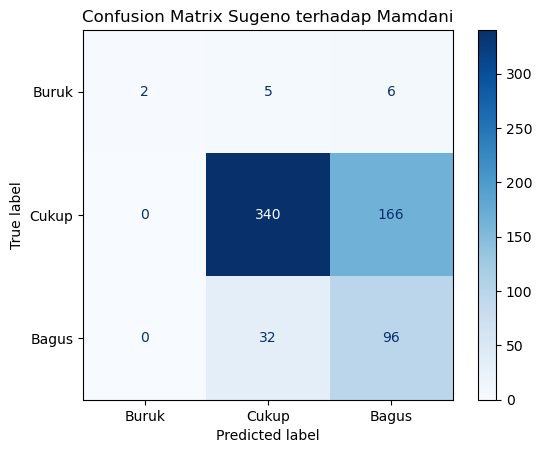

In [33]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=['Buruk', 'Cukup', 'Bagus'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buruk', 'Cukup', 'Bagus'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix Sugeno terhadap Mamdani")
plt.show()


## Distribution
### Bagian ini bertujuan untuk membandingkan distribusi nilai kinerja (performance scores) yang dihasilkan oleh sistem logika fuzzy Mamdani dan Sugeno. Plot distribusi ini divisualisasikan menggunakan kurva Kernel Density Estimation (KDE), yang menggambarkan kepadatan probabilitas dari nilai kinerja berdasarkan hasil simulasi fuzzy masing-masing metode.
### Dalam kode ini, dua kurva KDE digambarkan menggunakan seaborn.kdeplot, masing-masing mewakili nilai yang dihasilkan oleh metode Mamdani dan Sugeno. Kurva ini menunjukkan pola penyebaran nilai — apakah lebih menyebar, simetris, atau cenderung terfokus di rentang tertentu. Area di bawah kurva yang diisi (fill=True) memberikan gambaran visual yang lebih jelas mengenai seberapa besar dominasi nilai dalam rentang tertentu.
### Dengan visualisasi ini, pengguna dapat mengamati apakah kedua metode menghasilkan distribusi yang serupa atau terdapat perbedaan signifikan, baik dari segi rata-rata nilai kinerja maupun sebarannya. Ini penting untuk mengevaluasi keselarasan kedua metode dalam menilai performa kendaraan berdasarkan input fuzzy.

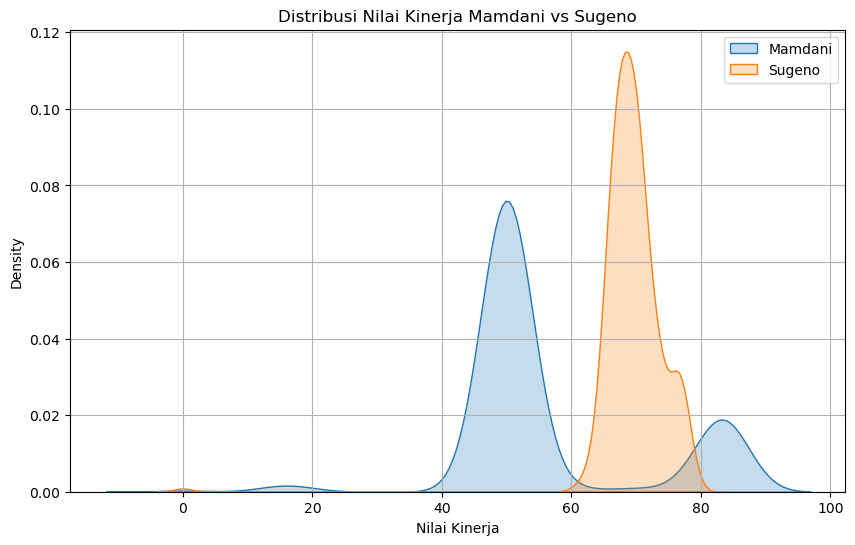

In [37]:
# Konversi ke float
results_df['Skor Mamdani'] = pd.to_numeric(results_df['Skor Mamdani'], errors='coerce')
results_df['Skor Sugeno'] = pd.to_numeric(results_df['Skor Sugeno'], errors='coerce')
plt.figure(figsize=(10, 6))
sns.kdeplot(results_df['Skor Mamdani'], label='Mamdani', fill=True)
sns.kdeplot(results_df['Skor Sugeno'], label='Sugeno', fill=True)
plt.title('Distribusi Nilai Kinerja Mamdani vs Sugeno')
plt.xlabel('Nilai Kinerja')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
